In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM
from PFNExperiments.LinearRegression.Models.Transformer_CNF import TransformerCNFConditionalDecoder
from PFNExperiments.Training.FlowMatching.CFMLossOT2 import CFMLossOT2
from PFNExperiments.LatentFactorModels.Training.TrainerCurriculumCNF_LatentFactor import TrainerCurriculumCNF_LatentFactor
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF import ModelToPosteriorCNF
from PFNExperiments.LatentFactorModels.ComparisonModels.Hamiltionian_MC import Hamiltionian_MC
from PFNExperiments.Evaluation.Evaluate import Evaluate, results_dict_to_data_x_tuple, result_dict_to_latent_variable_convert_mu_sigma_to_beta, results_dict_to_data_x_tuple_transpose

In [5]:
from PFNExperiments.LatentFactorModels.GenerativeModels.Clustering.GMMs import make_gmm_program_univariate, make_gmm_program_univariate_batched
from PFNExperiments.LatentFactorModels.GenerativeModels.LatenFactorModel_abstract import return_only_x

from PFNExperiments.LatentFactorModels.ComparisonModels.MakeDefaultListComparison import make_default_list_comparison, make_reduced_list_comparison


In [6]:
N = 10
P = 4
K = 3
BATCH_SIZE = 1024
N_EPOCHS = 100
N_SAMPLES_PER_EPOCH = 500_000
N_BATCHES_PER_EPOCH = N_SAMPLES_PER_EPOCH//BATCH_SIZE

In [7]:
curriculum = Curriculum(max_iter=int(N_EPOCHS*N_BATCHES_PER_EPOCH*BATCH_SIZE*0.5))
curriculum.add_param_list([
    ("n", curriculum.constant_scheduler(N)),
    ("p", curriculum.constant_scheduler(P)),
    ("batch_size", curriculum.constant_scheduler(BATCH_SIZE)),
    ("a1", curriculum.constant_scheduler(5.0)),
    ("b1", curriculum.constant_scheduler(2.0)),
    ("dirichlet_beta", curriculum.constant_scheduler(1.0)),
    ("lambda1", curriculum.constant_scheduler(3.0))
])
#curriculum.plot_all_schedules()

In [9]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_gmm_program_univariate_batched,
    curriculum= curriculum,
)

pprogram_covariates_train is None, using pprogram_covariates instead
pprogram_covariates_val is None, using pprogram_covariates instead
pprogram_covariates_test is None, using pprogram_covariates instead


In [10]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
    )

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [11]:
sample_batch = next(iter(epoch_loader[0][0]))

####################################################################################################
Epoch 0


100%|██████████| 10/10 [00:00<00:00, 48.12it/s]


{'X': {'mean': tensor(0.0312), 'variance': tensor(3.7833), 'min': tensor(-28.0397), 'max': tensor(43.1404), 'mean_mean': tensor([0.0312]), 'variance_mean': tensor([2.3908]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(0.2666), 'variance': tensor(1.6669), 'min': tensor(-23.5913), 'max': tensor(36.5064), 'mean_mean': tensor(0.2666), 'variance_mean': tensor(1.7262), 'min_mean': None, 'max_mean': None}}
Statistics for phi:
Mean: tensor([0.2491, 0.2509, 0.2481, 0.2519])
Variance: tensor([0.0382, 0.0361, 0.0382, 0.0386])
Min: tensor([0.0002, 0.0001, 0.0003, 0.0002])
Max: tensor([0.9265, 0.9076, 0.9834, 0.9336])
Mean of means: 0.25
Mean of variances: 0.05035809800028801
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([0.0201, 0.0064, 0.0265, 0.0633])
Variance: tensor([3.6130, 3.1991, 3.4188, 2.7444])
Min: tensor([-12.0771, -14.4095, -23.5913, -13.6308])
Max: tensor([36.5064, 15.3419, 18.3628, 11.3500])
Mean of means: 0.029055338352918625
Mean o

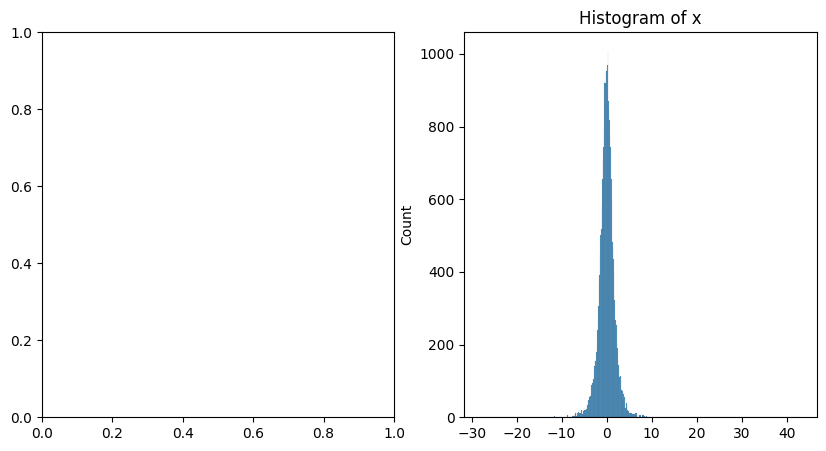

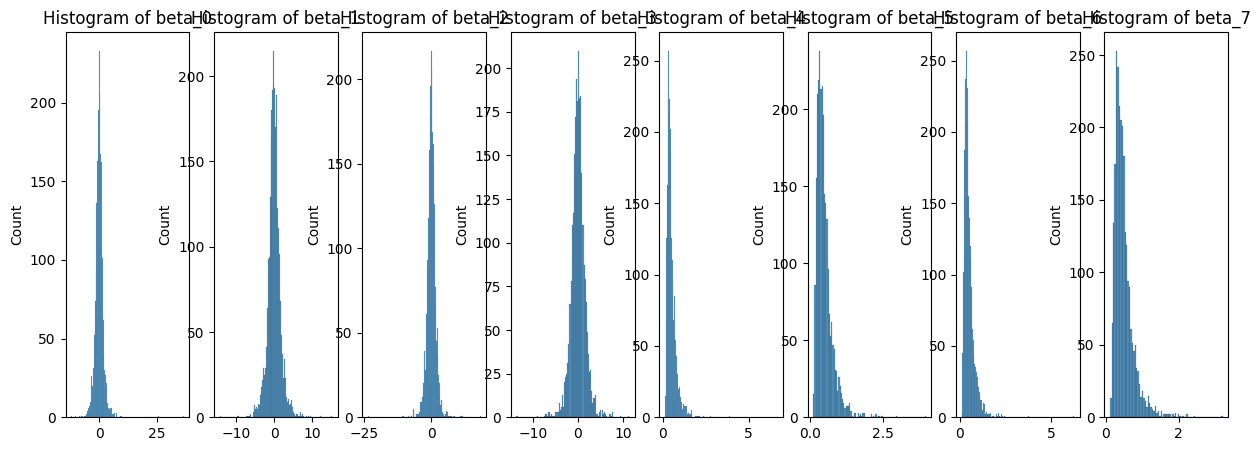

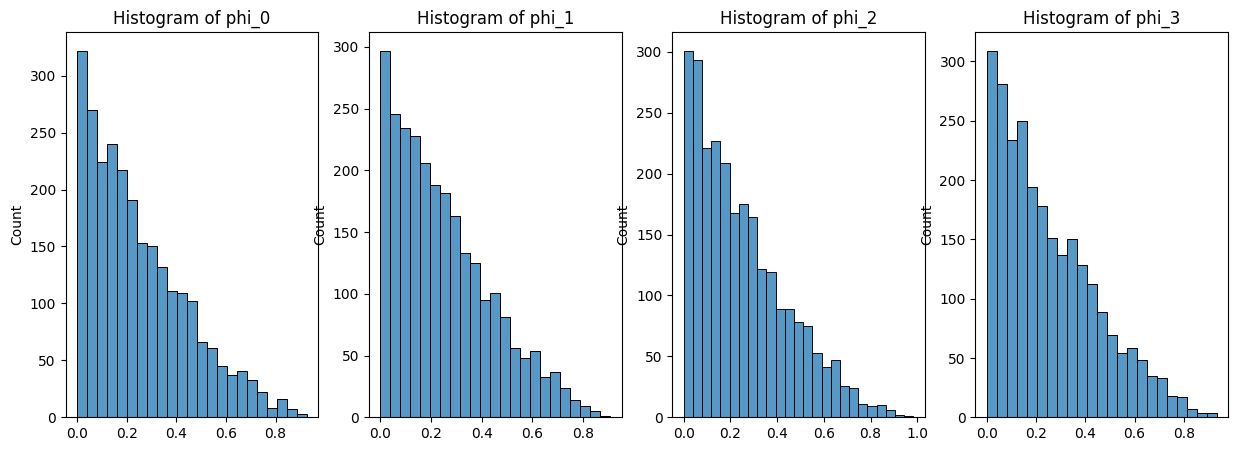

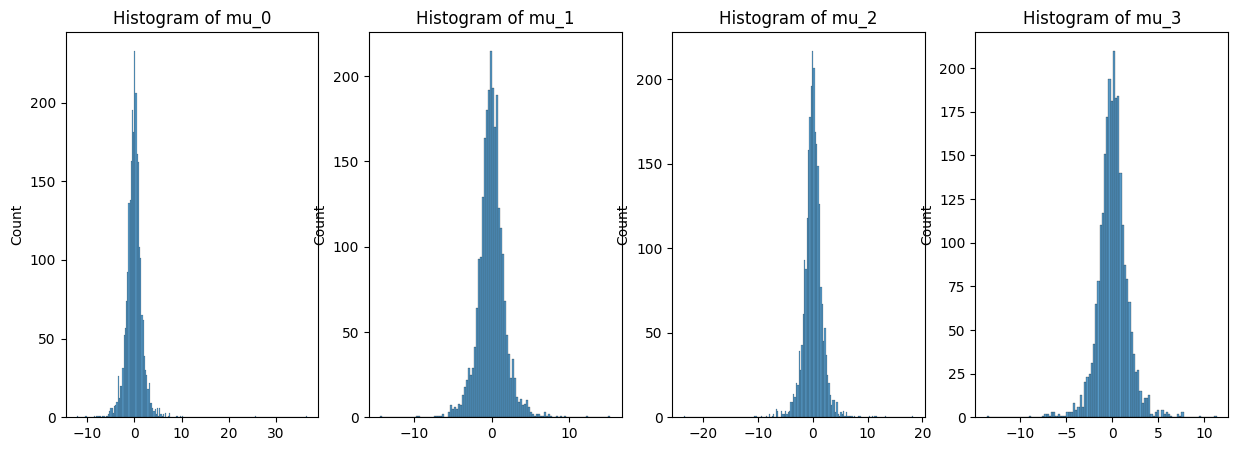

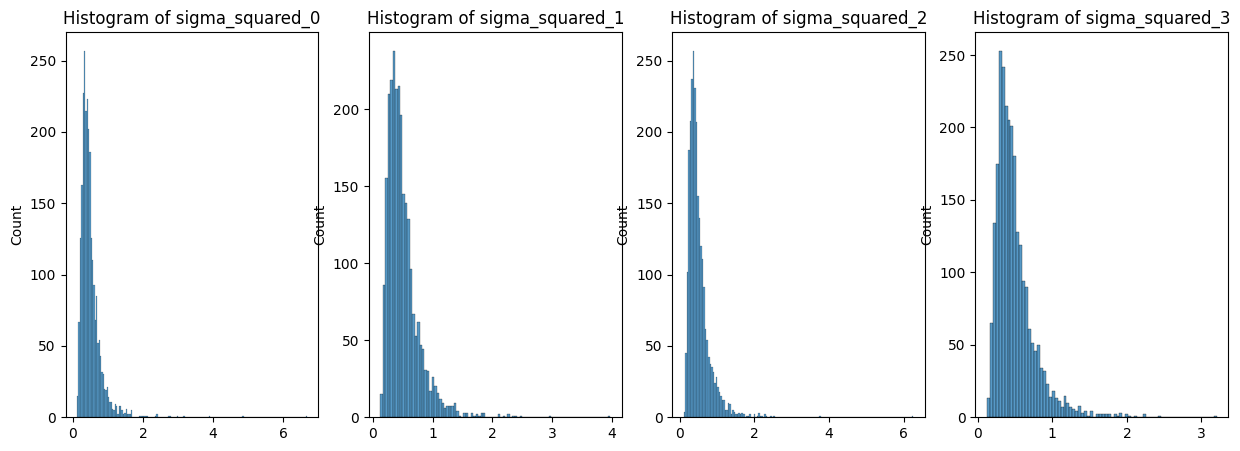

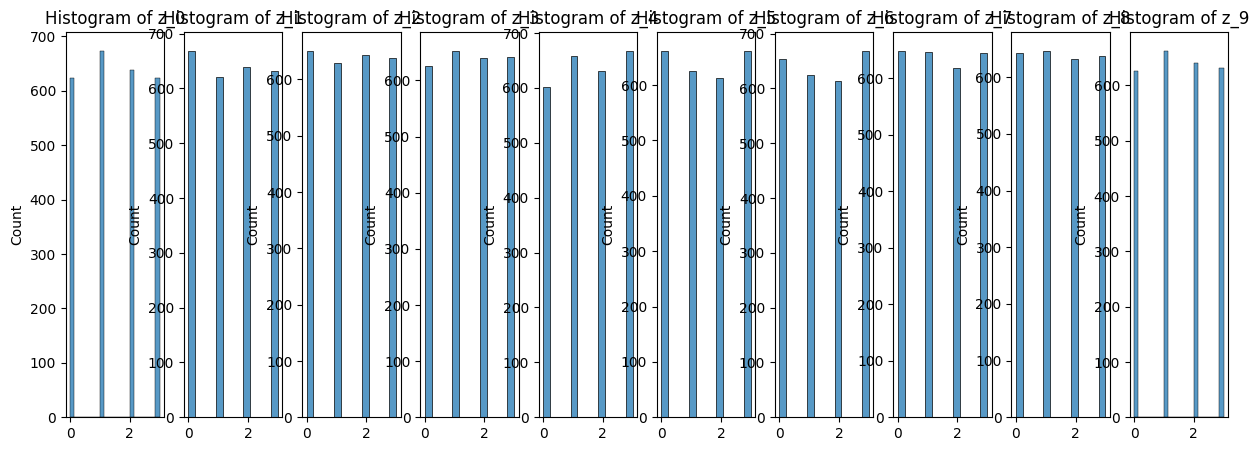

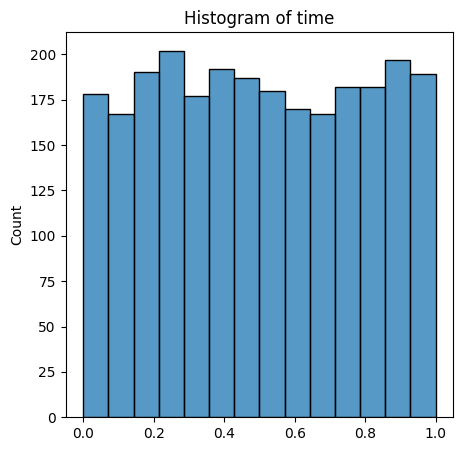

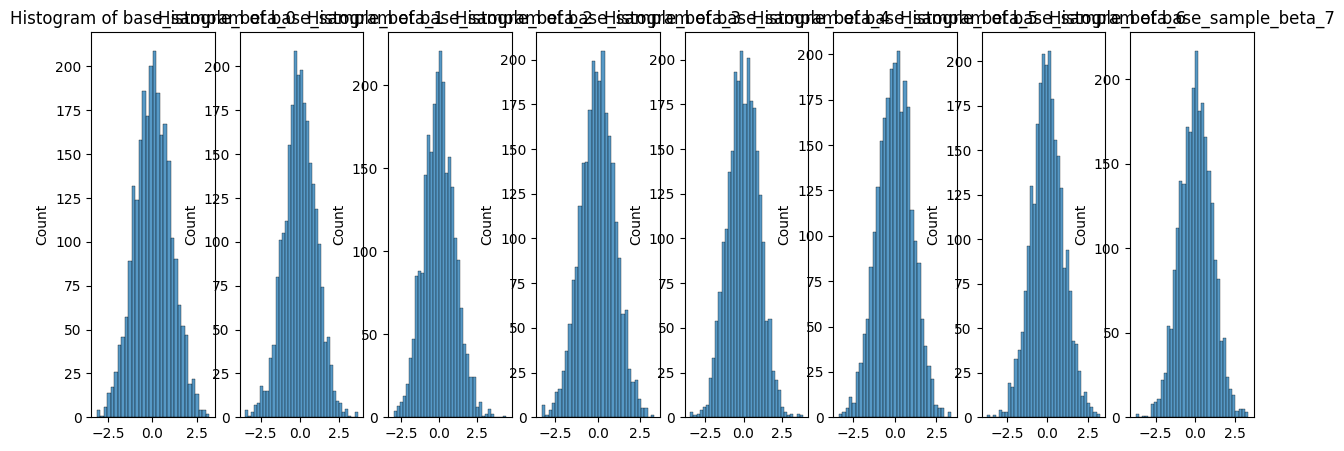

####################################################################################################
Epoch 99


100%|██████████| 10/10 [00:00<00:00, 50.77it/s]


{'X': {'mean': tensor(-0.0199), 'variance': tensor(3.2655), 'min': tensor(-23.0312), 'max': tensor(22.1862), 'mean_mean': tensor([-0.0199]), 'variance_mean': tensor([2.0958]), 'min_mean': None, 'max_mean': None}, 'beta': {'mean': tensor(0.2400), 'variance': tensor(1.5362), 'min': tensor(-21.2847), 'max': tensor(15.5521), 'mean_mean': tensor(0.2400), 'variance_mean': tensor(1.6148), 'min_mean': None, 'max_mean': None}}
Statistics for phi:
Mean: tensor([0.2550, 0.2513, 0.2477, 0.2460])
Variance: tensor([0.0392, 0.0380, 0.0381, 0.0370])
Min: tensor([2.0284e-04, 1.9426e-04, 3.8750e-05, 1.6020e-04])
Max: tensor([0.9667, 0.9334, 0.9272, 0.9841])
Mean of means: 0.25
Mean of variances: 0.05073554441332817
Mean of minimums: None
Mean of maximums: None


Statistics for mu:
Mean: tensor([-0.0141, -0.0304, -0.0026, -0.0254])
Variance: tensor([2.8295, 3.0239, 3.1888, 2.9155])
Min: tensor([-15.6991, -15.1507, -21.2847,  -9.5755])
Max: tensor([10.2914, 14.0796, 12.9446, 15.5521])
Mean of means: -0.01

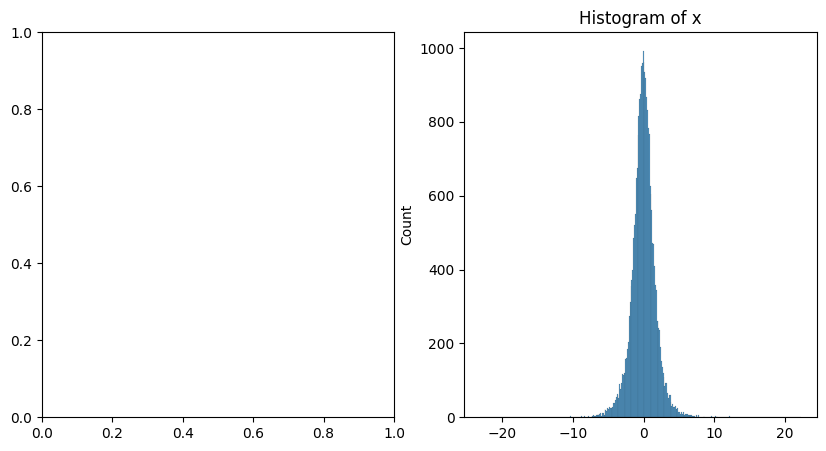

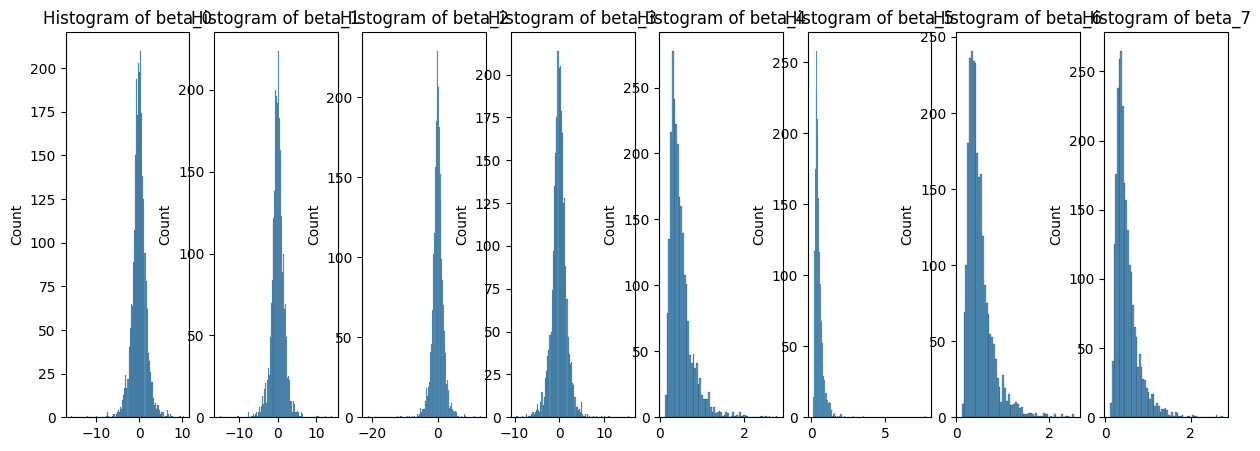

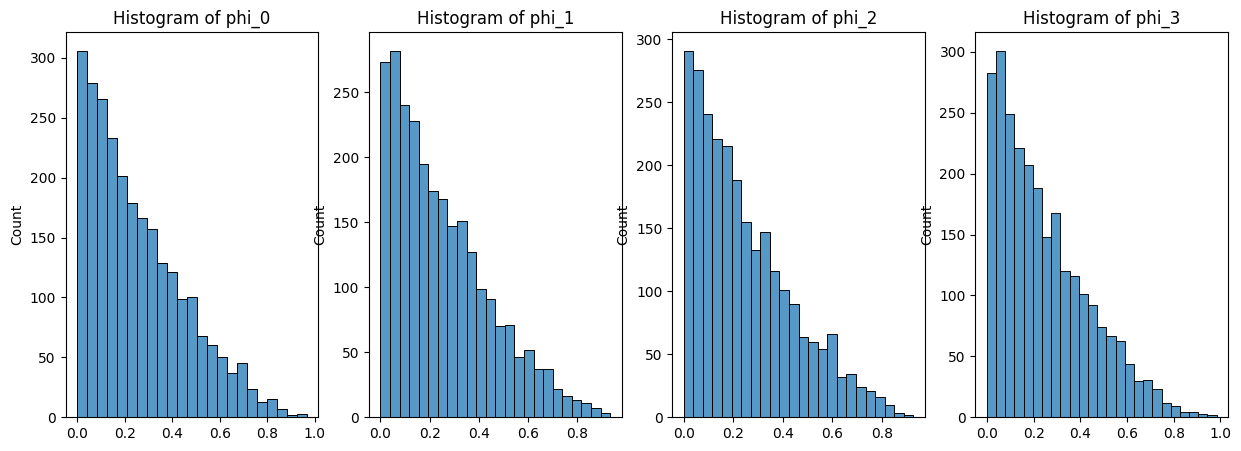

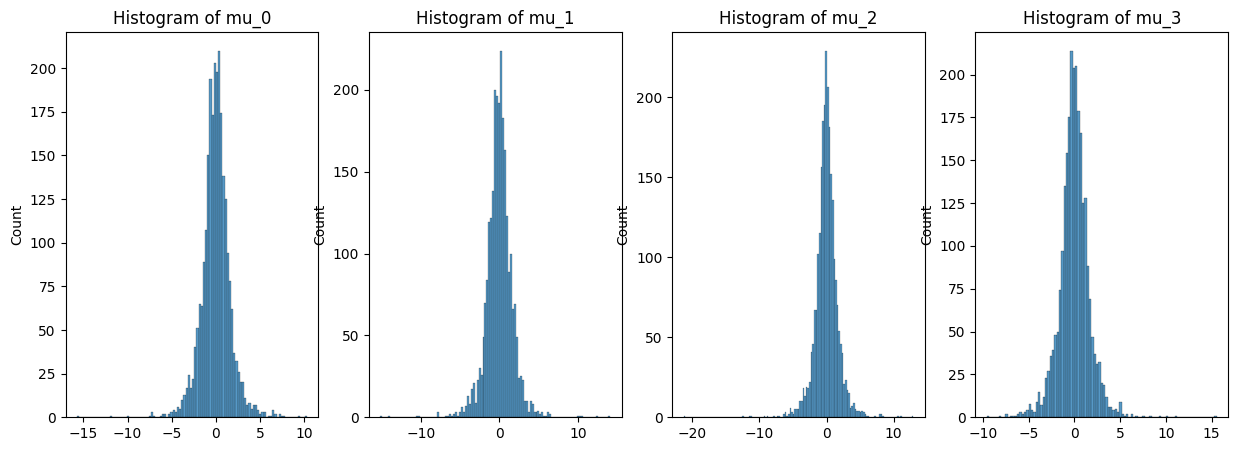

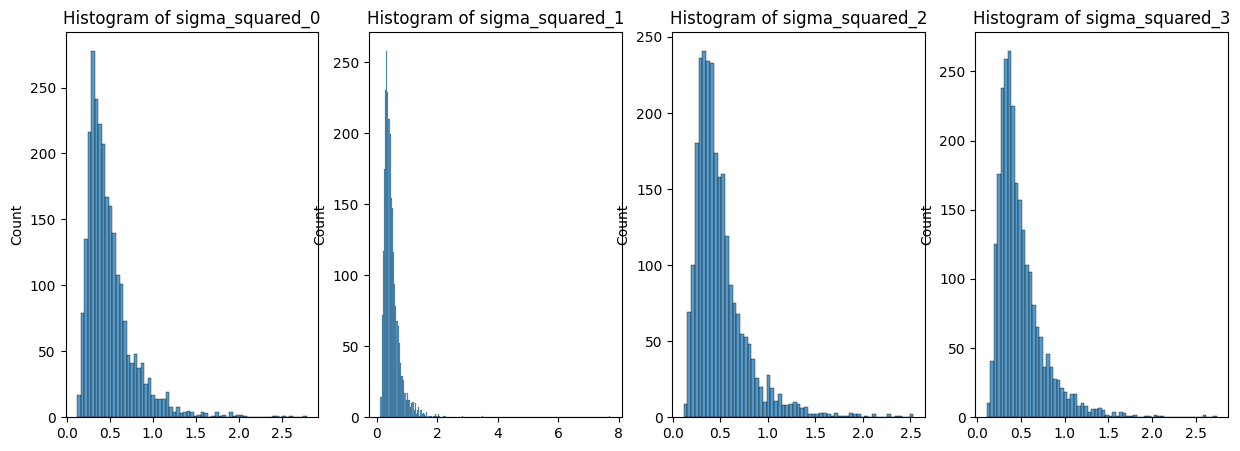

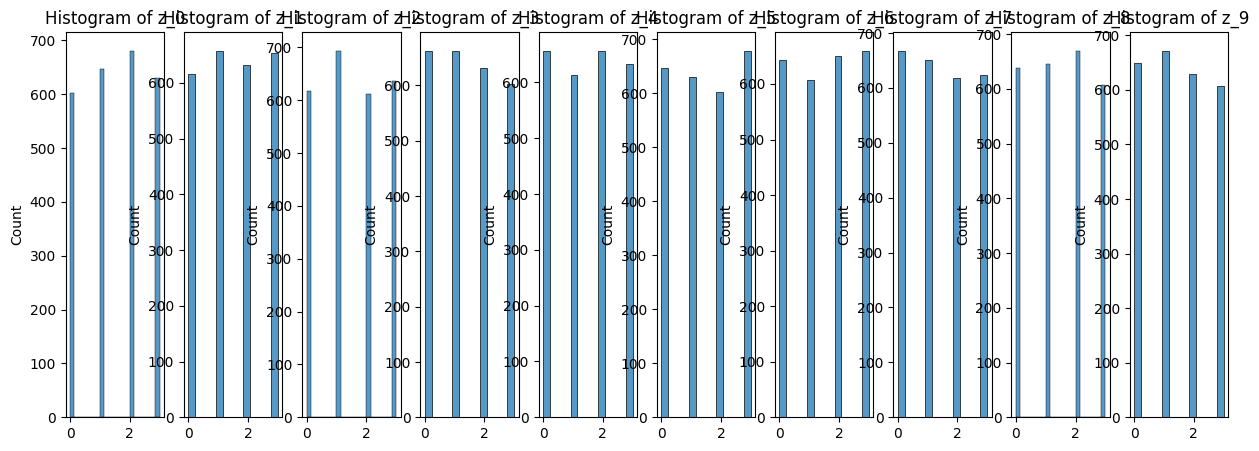

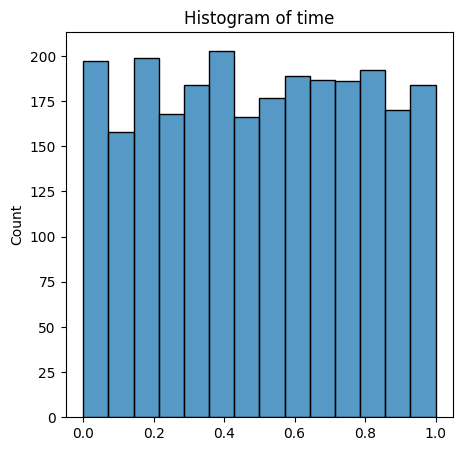

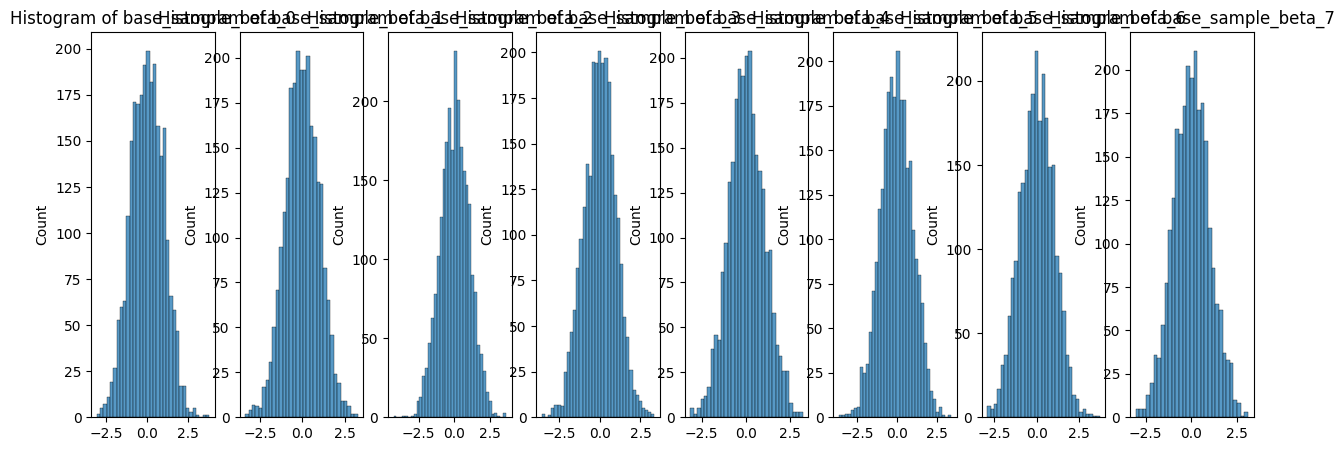

In [13]:
check_res = data_generator.check_model(
    n_samples_per_epoch=N_SAMPLES_PER_EPOCH,
    epochs_to_check = [0, N_EPOCHS-1],
    p = P,
    n = N,
    used_batch_samples = 10
)

In [14]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
)

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [15]:
sample_batch = next(iter(epoch_loader[0][0]))
sample_batch.keys()

dict_keys(['phi', 'mu', 'sigma_squared', 'z', 'x', 'beta', 'time', 'base_sample_beta'])

In [16]:
sample_batch["x"].shape, sample_batch["beta"].shape

(torch.Size([1024, 10, 1]), torch.Size([1024, 8]))

In [17]:
2*K

6

In [39]:
"""
model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = 1,
    n_input_features_decoder = 2*P,
    d_model_encoder = 512,
    d_model_decoder = 512,
    n_heads_encoder = 8,
    n_heads_decoder = 8,
    d_ff_encoder = 1024,
    d_ff_decoder = 1024,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 512,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = 2*P,
    d_final_processing = 512,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)
"""

model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = 1,
    n_input_features_decoder = 2*P,
    d_model_encoder = 16,
    d_model_decoder = 16,
    n_heads_encoder = 1,
    n_heads_decoder = 1,
    d_ff_encoder = 16,
    d_ff_decoder = 16,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 16,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = 2*P,
    d_final_processing = 16,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)

In [40]:
loss_fun = CFMLossOT2(
    sigma_min=1e-4
)

In [41]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = OneCycleLR(opt,
                       max_lr = 5e-4,
                       epochs = N_EPOCHS,
                       steps_per_epoch = N_SAMPLES_PER_EPOCH//BATCH_SIZE,
                       pct_start = 0.1,
                       div_factor=25.0,
                       final_div_factor=1e4)

#scheduler = ReduceLROnPlateau(opt)

additional_evals = {
}



In [42]:
trainer = TrainerCurriculumCNF_LatentFactor(
    model = model,
    optimizer=opt,
    scheduler = scheduler,
    loss_function=loss_fun,
    epoch_loader = epoch_loader,
    evaluation_functions= additional_evals,
    n_epochs = N_EPOCHS,
    early_stopping_patience = 200,
    schedule_step_on = "batch",
    save_path = None,
    coupling = None,
    use_same_timestep_per_batch = False,
    use_train_mode_during_validation = False,
    max_gradient_norm = 1.0

)

In [43]:
trainer.validate()

100%|██████████| 49/49 [00:13<00:00,  3.53it/s]


{'loss_mean': 2.7540831565856934,
 'loss_median': 2.751993179321289,
 'loss_std': 0.10253439098596573}

In [44]:
r = trainer.train()

Curriculum parameters: {'n': 10, 'p': 4, 'batch_size': 1024, 'a1': 5.0, 'b1': 2.0, 'dirichlet_beta': 1.0, 'lambda1': 3.0} at iteration 0


100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Epoch 0:
Training: {'loss_mean': 3.147815704345703, 'loss_median': 3.1245338916778564, 'loss_std': 0.15482036769390106}
Validation: {'loss_mean': 2.722158432006836, 'loss_median': 2.7141029834747314, 'loss_std': 0.07545348256826401}
Validation curriculum: {'loss_mean': 2.7031972408294678, 'loss_median': 2.6992287635803223, 'loss_std': 0.07125847041606903}
Time: 121.75331974029541
Learning rate: [2.2956007119594385e-05]


----------------------------------------------------------------------------------------------------
Saving model
Curriculum parameters: {'n': 10, 'p': 4, 'batch_size': 1024, 'a1': 5.0, 'b1': 2.0, 'dirichlet_beta': 1.0, 'lambda1': 3.0} at iteration 249856


  0%|          | 0/244 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [49]:
full_model = ModelToPosteriorCNF(
    model = model.eval(),
    sample_name = "beta",
    sample_shape = (2*P,),
    n_samples=1000,
    batch_size = BATCH_SIZE,
    solve_adjoint = True,
    atol = 10,
    rtol = 10,
    #device = torch.device("cpu")
)

benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
del benchmark_params_ppgrogram["batch_size"]
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_gmm_program_univariate(**benchmark_params_ppgrogram)

pprogram1_x = return_only_x(pprogram1)



params for pprogram: {'n': 10, 'p': 4, 'a1': 5.0, 'b1': 2.0, 'dirichlet_beta': 1.0, 'lambda1': 3.0}


In [50]:
test_batch = next(iter(epoch_loader[0][1]))
x_test = test_batch["x"]

In [51]:
x_test.shape

torch.Size([1024, 10, 1])

In [52]:
full_model.sample_posterior(x_test[0])

0it [00:00, ?it/s]


{'beta': tensor([[ 132853.5312,  318656.1562, -155640.2188,  ...,  -27266.5352,
           -27704.2246,   48387.3984],
         [ 132835.5312,  318715.8750, -155374.5938,  ...,  -27213.0762,
           -27701.1035,   48351.0938],
         [ 132835.6719,  318744.3750, -155370.1250,  ...,  -27230.6562,
           -27711.8008,   48351.6055],
         ...,
         [ 132849.4688,  318669.1875, -155533.9688,  ...,  -27235.4844,
           -27699.0625,   48372.5391],
         [ 132819.8125,  318807.5312, -155210.6562,  ...,  -27223.0371,
           -27723.3945,   48327.2578],
         [ 132832.0625,  318762.9375, -155322.1094,  ...,  -27224.7969,
           -27714.5996,   48345.9531]], grad_fn=<CatBackward0>),
 'X': tensor([[-0.1675],
         [ 0.6462],
         [-1.4283],
         [-0.4522],
         [ 2.4619],
         [ 2.6801],
         [-0.4706],
         [-0.6838],
         [ 0.5753],
         [ 5.2308]]),
 'y': None}

In [53]:
hmc = Hamiltionian_MC(
    pprogram=pprogram1_x,
    n_samples=500,
    n_warmup=500
)

models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 1000)

In [54]:
evaluation = Evaluate(
    posterior_model = full_model,
    evaluation_loader = trainer.testset,
    comparison_models= models[1:],
    n_evaluation_cases=2,
    save_path= None,
    overwrite_results = True,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_mu_sigma_to_beta,
    result_dict_to_data_for_comparison_models= results_dict_to_data_x_tuple_transpose
)

In [55]:
evaluation.run_evaluation()

Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

Key: phi, value shape: torch.Size([1, 4])
Key: mu, value shape: torch.Size([1, 4])
Key: sigma_squared, value shape: torch.Size([1, 4])
Key: z, value shape: torch.Size([1, 10])
Key: x, value shape: torch.Size([1, 10, 1])
Key: beta, value shape: torch.Size([1, 8])
Key: time, value shape: torch.Size([1])
Key: base_sample_beta, value shape: torch.Size([1, 8])


0it [00:00, ?it/s]
Sampling posterior:  50%|█████     | 1/2 [00:01<00:01,  1.07s/it]

Key: phi, value shape: torch.Size([1, 4])
Key: mu, value shape: torch.Size([1, 4])
Key: sigma_squared, value shape: torch.Size([1, 4])
Key: z, value shape: torch.Size([1, 10])
Key: x, value shape: torch.Size([1, 10, 1])
Key: beta, value shape: torch.Size([1, 8])
Key: time, value shape: torch.Size([1])
Key: base_sample_beta, value shape: torch.Size([1, 8])


0it [00:00, ?it/s]
Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

Key: phi, value shape: torch.Size([1, 4])
Key: mu, value shape: torch.Size([1, 4])
Key: sigma_squared, value shape: torch.Size([1, 4])
Key: z, value shape: torch.Size([1, 10])
Key: x, value shape: torch.Size([1, 10, 1])
Key: beta, value shape: torch.Size([1, 8])
Key: time, value shape: torch.Size([1])
Key: base_sample_beta, value shape: torch.Size([1, 8])
Data: (tensor([-0.5836,  1.3715, -0.9135,  1.4073, -0.4826, -0.6777, -0.1511, -1.1115,
        -0.7719, -0.8556]), None)
Data shape: torch.Size([10])
..

Sampling posterior:   0%|          | 0/2 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [56]:
from PFNExperiments.Evaluation.RealWorldEvaluation.PreprocessDataset import Preprocessor, PreprocessorClassification

In [61]:
check_res[1]["X"]["variance_mean"]

tensor([2.0958])

In [57]:
from PFNExperiments.Evaluation.RealWorldEvaluation.Preprocess_univariate_GMM import Preprocessor_GMM_univariate
from PFNExperiments.Evaluation.RealWorldEvaluation.GetDataOpenML import GetDataOpenML
getdata = GetDataOpenML(
    preprocessor = Preprocessor_GMM_univariate(
        N_datapoints = N,
        x_mean = 0.0,
        x_var = 1.0,
    ),
    save_path = "C:/Users/arik_/Documents/Dokumente/Job_Clausthal/PFNs/Repository/PFNExperiments/Evaluation/RealWorldEvaluation/DatasetsOpenML/Tabular_benchmark_numerical_regression.pkl",
    benchmark_id = 336
)
datasets = getdata.get_data()

In [ ]:
datasets[0]["x"].shape

torch.Size([10, 1])

In [ ]:
comparison_models = make_default_list_comparison(pprogram= pprogram1_x, n_samples= 1000)

In [ ]:
from PFNExperiments.Evaluation.RealWorldEvaluation.EvaluateRealWorld import EvaluateRealWorld


eval = EvaluateRealWorld(
    
    posterior_model = full_model,
    evaluation_datasets = datasets,
    comparison_models = comparison_models[1:3],
    n_evaluation_cases = 2,
    results_dict_to_data_for_model = results_dict_to_data_x_tuple,
    results_dict_to_latent_variable_comparison_models= result_dict_to_latent_variable_convert_mu_sigma_to_beta
)

In [ ]:
eval.run_evaluation()


0it [00:00, ?it/s]

0it [00:00, ?it/s]
Sampling posterior: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


....................


....................


Sampling posterior: 100%|██████████| 2/2 [01:03<00:00, 31.59s/it]


....................


....................


Sampling posterior: 100%|██████████| 2/2 [01:05<00:00, 32.98s/it]


Comparison to ground truth:

Summarized results:

Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,3.315322,2.176648,0.9985,0.356501,0.213406,0.000707
1,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,2.984874,1.713836,0.9980,0.422907,0.027648,0.002121
2,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,3.369114,4.218278,1.0000,1.181957,0.256180,0.000000


P-values:


,Pair 1: Model A,Pair 1: Model B,Pair 2: Model A,Pair 2: Model B,Wasserstein_distance with metric euclidean_p-value,MMD_p-value,cst_roc_auc_p-value
0,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,0.666667,0.333333,1.000000
1,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,1.000000,0.245278,0.220671
2,<PFNExperiments.LinearRegression.Models.ModelT...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,Variational Inference with guide: _bound_parti...,1.000000,0.245278,0.220671


{'summarized_results': {'model_comparison_among_each_other':                                              Model 1  \
  0  <PFNExperiments.LinearRegression.Models.ModelT...   
  1  <PFNExperiments.LinearRegression.Models.ModelT...   
  2  Variational Inference with guide: _bound_parti...   
  
                                               Model 2  \
  0  Variational Inference with guide: _bound_parti...   
  1  Variational Inference with guide: _bound_parti...   
  2  Variational Inference with guide: _bound_parti...   
  
     Mean_Wasserstein_distance with metric euclidean  Mean_MMD  \
  0                                         3.315322  2.176648   
  1                                         2.984874  1.713836   
  2                                         3.369114  4.218278   
  
     Mean_cst_roc_auc  Std_Wasserstein_distance with metric euclidean   Std_MMD  \
  0            0.9985                                        0.356501  0.213406   
  1            0.9980                 